In [1]:
from link_bot_notebooks import notebook_finder
from link_bot_notebooks import toy_problem_optimization_common as tpo
import numpy as np
import matplotlib.pyplot as plt

importing Jupyter notebook from /home/pmitrano/catkin_ws/src/link_bot/link_bot_notebooks/src/link_bot_notebooks/toy_problem_optimization_common.ipynb


In [2]:
g = np.array([[4], [0], [5], [0], [6], [0]])
dt = 0.1

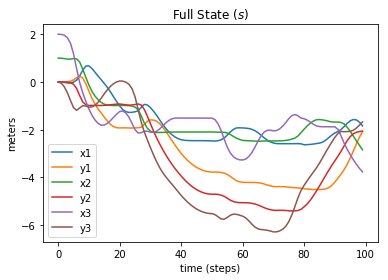

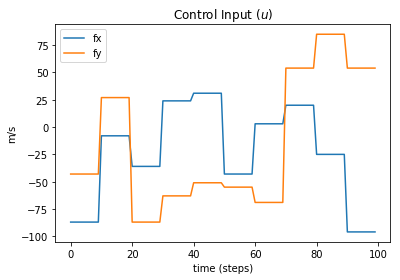

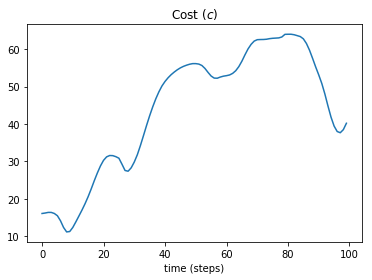

In [3]:
data = tpo.load_gazebo_data_v2("/home/pmitrano/catkin_ws/src/link_bot/link_bot_teleop/data/rand_forces_1.txt", g)
tpo.plot_gz_data_v2(data[:100])

# Random Params

In [15]:
N = 100
costs = np.zeros(N)
rand_model = tpo.LinearStateSpaceModelWithQuadraticCost(N=6, M=2, L=2)
for i in range(N):
    random_params = np.random.randn(model.size())
    rand_model.from_params(random_params)
    costs[i] = tpo.state_prediction_objective(rand_model, g, data, dt)
print("Median cost for random parameters {:.3f}".format(np.median(costs)))

Median cost for random parameters 412154.690


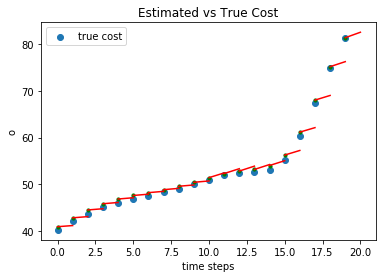

In [14]:
tpo.plot_cost(rand_model, data[100:120], dt, g)

In [6]:
tpo.mean_dot_product(rand_model, data, dt, g)

-11.747489179038174

# Train

In [9]:
np.random.seed(123)
model = tpo.LinearStateSpaceModelWithQuadraticCost(N=6, M=2, L=2)
result = tpo.train(data, model, g, dt, tpo.one_step_cost_prediction_objective, tol=0.1, method='CG', options={'maxiter': 10000})

Status: 2, Message: Desired error not necessarily achieved due to precision loss.


In [16]:
tpo.eval_model(model, data, g, dt);

Loss Components:
	current cost: 0.530238379818
	predict next latent state: 0.462902922407
	predict next cost: 11.0506024376
	regularization: 5.02454225799e-05
Complete Losses:
	predict next latent state and current cost: 0.496620896535
	predict next cost and current cost: 5.79047065412

Model reduction Matrix: [[ 2.31  2.07  0.12  0.03 -0.05  0.11]
 [-1.17  3.72 -0.07 -0.24 -0.07  0.46]]
 Dynamics matrices: [[-0.    0.01]], [[ 0.    0.01]
 [-0.05  0.02]]
 Cost Matrix: [[ 0.11 -0.21]
 [ 0.14  0.07]]


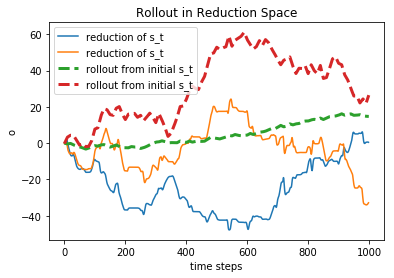

In [17]:
tpo.plot_o_rollout(model, data, dt, g)

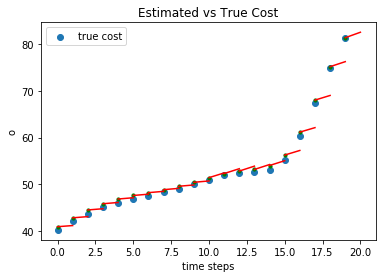

In [18]:
tpo.plot_cost(model, data[100:120], dt, g)

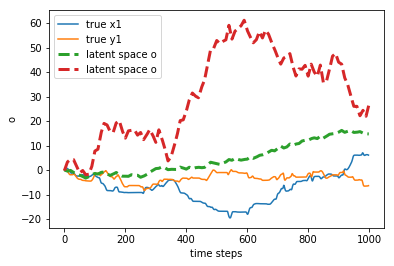

In [19]:
tpo.plot_xy_rollout(model, data, dt, data[0][0], g);

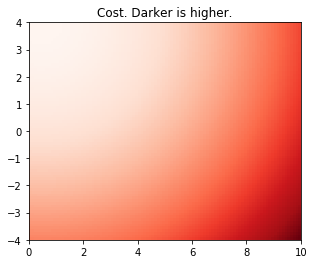

In [20]:
def plot_costmap(model, g, bounds=[0, 10, -4, 4], resolution=0.1):
    n = int((bounds[1] - bounds[0]) / resolution)
    m = int((bounds[3]-bounds[2]) / resolution)
    costmap = np.ndarray((m, n))
    
    for x in range(0, n):
        for y in range(0, m):
            s = np.array([[x], [y], [x+1], [y], [x+2], [y]])
            costmap[y][x] = model.cost_of_s(s, g)
            

    plt.title("Cost. Darker is higher.")
    plt.imshow(costmap, cmap=plt.cm.Reds, interpolation='none', extent=bounds)
    
plot_costmap(model, g)

In [21]:
print("Mean dot product of predicted change in cost with true change in cost (over one step): ")
print(tpo.mean_dot_product(model, data, dt, g))

Mean dot product of predicted change in cost with true change in cost (over one step): 
1.6382934783597451


In [23]:
model.save("rand_forces_model_1.npz")